In [276]:
%matplotlib inline  
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
import upsetplot

# This notebook was used to process the REDCap forms of TCAG samples that are sequenced. 

*  Extract the relationship b/w participants to match case-control
*  Remove the GM prefix added to all IDs: handled in cell (redcap_lhsc)
*  duplicate participant record: handled in (redcap_ont)

This should be commented/removed once the forms from REDCap are updated and downloaded.
Run each code cells, and comment out unwanted print statement

# Store the genMARK <-> TCAG ID mappings to dataframe

Total N = 1393
Sequenced data = 1123
Redcap data missing for sequenced = 11

In [367]:
#Filter for samples that are sequenced and extract the info for the same from REDCap
genmark_2_tcag = pd.read_csv("genmark_to_tcag.tsv", sep="\t",names=["genmark_id", "tcag_id","seq_available"])
genmark_2_tcag = genmark_2_tcag[genmark_2_tcag['seq_available'] == True ]
genmark_2_tcag.count()


genmark_id       1123
tcag_id          1123
seq_available    1123
dtype: int64

# REDCap form
1. Read ONTARIO, Bahamas, and LHSC REDcap forms

In [368]:
redcap_ont = pd.read_csv("CoreCaseRecordForm_DATA_LABELS_2024-05-23_0025_ONT.csv" ,dtype={"Participant ID #:": str },low_memory=False)
ont_columns = redcap_ont.columns.tolist()
ont_columns = [i.strip() for i in ont_columns]
# print("Ontario columns = ", ont_columns)

redcap_bah = pd.read_csv("CoreCaseRecordFormBa_DATA_LABELS_2024-05-23_0026_BAH.csv",dtype={"Participant ID #:": str })
bahamas_columns = redcap_bah.columns.tolist()
bahamas_columns = [i.strip() for i in bahamas_columns]
# print("Bahamas columns =", bahamas_columns)
#Record IDs 82-106, the participant IDs are without hyphen; edit that
#this is not the case; excel displays it wrong . IDs are okay


redcap_lhsc = pd.read_csv("GenMARKStudyCoreCase_DATA_LABELS_2024-05-23_0026_LHSC.csv",dtype={"Participant ID #:": str })

#currently all participant IDS have a "GM-" prefix, remove these
redcap_lhsc["Participant ID #:"] = redcap_lhsc["Participant ID #:"].str.lstrip("GM-")
lhsc_columns = redcap_lhsc.columns.tolist()
lhsc_columns = [i.strip() for i in lhsc_columns]
# print("LHSC columns = ", lhsc_columns)



In [289]:
print("Total records from all forms =", redcap_ont.shape[0]+ redcap_bah.shape[0]+ redcap_lhsc.shape[0])
print("len of ont_columns={}, bahamas_columns={}, lhsc_columns={}".format(len(ont_columns),len(bahamas_columns),len(lhsc_columns)))
x = list(set(bahamas_columns).intersection(lhsc_columns))
y = list(set(ont_columns).difference(x))
print("Intersecion Ontario (n) Bahamas (n) LHSC", len(y))

Total records from all forms = 1476
len of ont_columns=621, bahamas_columns=465, lhsc_columns=521
Intersecion Ontario (n) Bahamas (n) LHSC 157


# Questions:
1. Why is there a difference in the redcap form columns b/w from the three sites?
2. Fix if possible: The LHSC participant ID's have a "GM-" prefix, remove this at redcap side.
3. redcap_bah has 122 records, hostseq list shared by Maria has 107 records; (confirmed with Maria that these are correct, and they are waiting for the 15 samples to arrive)
    1. all of them have not sequqenced yet, is this correct?
    2. why does redcap form have extra 15 records?



# Copy ethnicity columns and set values to ethnicty for "checked" cells
1. Make the ehtnicity column names readable
2. Copy the original ethnicity columns to the reformatted column names in 1.
3. Change values in new ethnicity columns as
    Checked -> ethnicity
    Unchecked -> ""

In [369]:
def rename_and_reformat(df):
    '''creates columns with readable name for ethnicity and sets the ethnicity as values for checked cells and empty for Unchecked'''
    columns = df.columns.tolist()
    ethnicity_columns = [i for i in columns if "ethnic" in i.lower()]
    renamed_ethnicity_columns = {i: "_".join([i.split("(")[0].strip("6. ").split(" ")[0],i.split("(")[2].split("=")[1].strip(")")])  for i in ethnicity_columns}
    for k in renamed_ethnicity_columns:
        df[renamed_ethnicity_columns[k]] = df[k]
    new_ethnicity_columns = list(renamed_ethnicity_columns.values())
    # print(new_ethnicity_columns)
    for i in new_ethnicity_columns:
        val = i.split("_")[1]
        df.loc[df[i] == "Checked",i] =  val
        df.loc[df[i] == "Unchecked",i] = ""
    df[new_ethnicity_columns].head()
    return new_ethnicity_columns
    

new_ethnicity_columns1 = rename_and_reformat(redcap_ont)
new_ethnicity_columns2 = rename_and_reformat(redcap_bah)
new_ethnicity_columns3 = rename_and_reformat(redcap_lhsc)

new_ethnicity_columns = list(set(new_ethnicity_columns1 + new_ethnicity_columns2 + new_ethnicity_columns3))
print("New ethnicity columns with ethnicity as values=", new_ethnicity_columns)

New ethnicity columns with ethnicity as values= ['Ethnic_Arab', 'Ethnic_Latin American', 'Ethnic_Aboriginal/First Nations', 'Ethnic_West Asian', 'Ethnic_Unknown', 'Ethnic_White', 'Ethnic_South Asian', 'Ethnic_Black', 'Ethnic_Other', 'Ethnic_East Asian']


# Write to CSV
1. concatenate the values in ethnicity columns to a single column named "combined_ethnicity" and remove empty values(Unchecked
2. concatenate Ontario, Bahamas, and LHSC dataframes to one dataframe.
3. add TCAG sample ID column
4. grouby "combined_ethnicity" and write the counts, participant IDs to two csvs

In [370]:
def consolidate_ethnicity_cols(df, grpby_col, out_cols, summary_file, stats_file):
    df.groupby(grpby_col)['Participant ID #:'].size().to_csv(stats_file)
    df[out_cols].to_csv(summary_file)
    
    

redcap_ont['combined_ethnicity'] = redcap_ont[new_ethnicity_columns].agg(lambda col: ','.join(i for i in col if i != ""), axis=1)
redcap_bah['combined_ethnicity'] = redcap_bah[new_ethnicity_columns].agg(lambda col: ','.join(i for i in col if i != ""), axis=1)
redcap_lhsc['combined_ethnicity'] = redcap_lhsc[new_ethnicity_columns].agg(lambda col: ','.join(i for i in col if i != ""), axis=1)
output_columns = ['Participant ID #:','combined_ethnicity', '1. Suspected or proven acute novel Coronavirus (nCoV) infection:   ', 'Close contact* with a symptomatic confirmed or probable case of \tnCoV Infection', '10. Sex at Birth: ', '11. Estimated Age (Years OR Months)','34. Have you received vaccination for COVID-19?  ', "49. Please specify Score from Ordinal Scale:"]
frames = [redcap_ont[output_columns], redcap_bah[output_columns], redcap_lhsc[output_columns]]
redcap_all = pd.concat(frames)
#redcap["TCAG_ID"] = redcap

redcap_all.groupby('combined_ethnicity').size().to_csv("TCAG_ethnicity_stats.tsv", sep="\t")

# redcap_all[output_columns].to_csv("TCAG_summary_columns.tsv", sep="\t")


# merge redcap_all and genmark_2_tcag on genmark_id

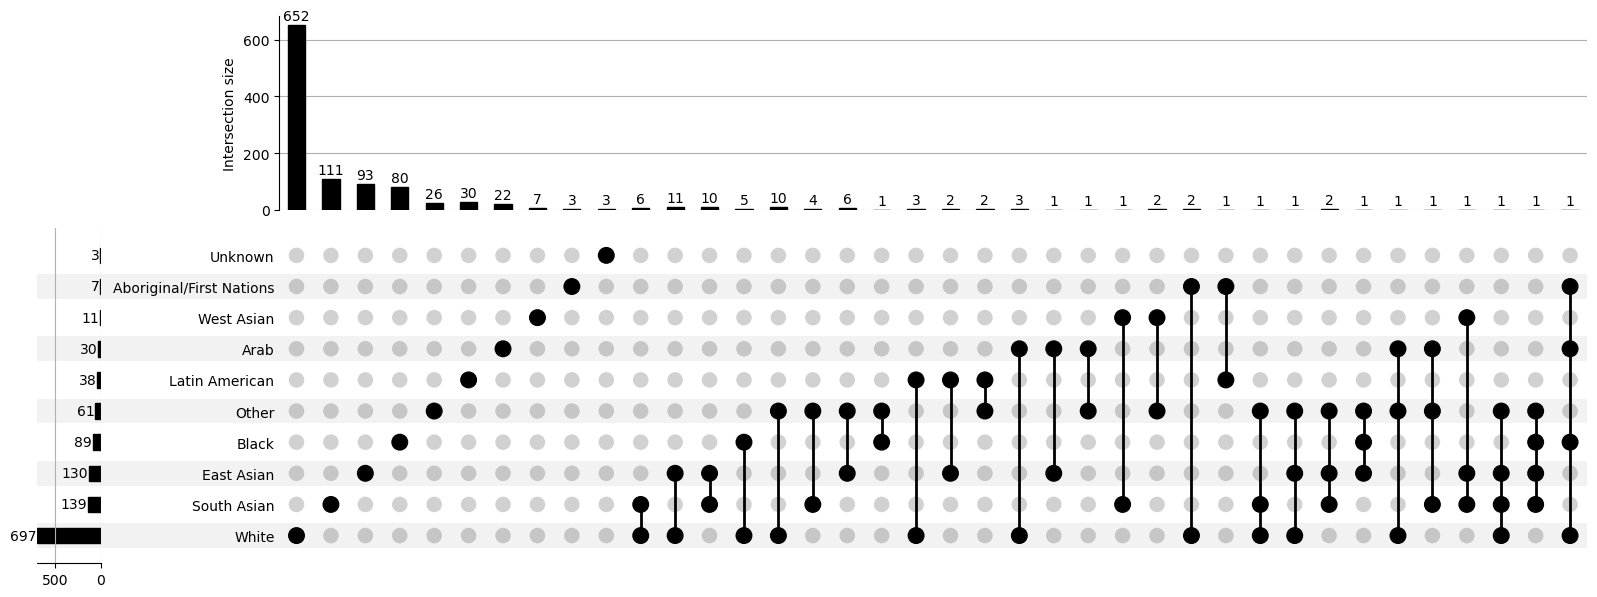

In [371]:
redcap_all_w_tcag_id = genmark_2_tcag.merge(redcap_all, how='inner', left_on="genmark_id", right_on="Participant ID #:")
output_columns += ['tcag_id','seq_available']
df = redcap_all_w_tcag_id.loc[redcap_all_w_tcag_id['seq_available'] == True][output_columns]

#replace empty string to NaN and replace " " in cell values with "_" as to_csv will output empty string
df['11. Estimated Age (Years OR Months)'] = df['11. Estimated Age (Years OR Months)'].str.replace(" ", "_",)
df['combined_ethnicity'] = df['combined_ethnicity'].str.replace(" ","_")
df.replace('', np.nan,inplace=True)

#make column names readable
col_renames = {'Participant ID #:':'participant_id', '1. Suspected or proven acute novel Coronavirus (nCoV) infection:   ': 'Suspected_COVID',\
 'Close contact* with a symptomatic confirmed or probable case of \tnCoV Infection': 'close_contact_w_case', \
 '10. Sex at Birth: ': 'Sex', '11. Estimated Age (Years OR Months)': 'Age',\
 '34. Have you received vaccination for COVID-19?  ':'COVID_Vaccination', "49. Please specify Score from Ordinal Scale:":'severity_score'}

df.rename(columns=col_renames, inplace=True)
df.to_csv("TCAG_summary_columns.tsv", sep="\t",index=False,na_rep='N/A')

ethnicity_val = [i.split("_")[1] for i in new_ethnicity_columns]
upset_df = upsetplot.from_contents({i: redcap_all_w_tcag_id.loc[redcap_all_w_tcag_id['combined_ethnicity'].str.contains(i), "tcag_id"].tolist() for i in ethnicity_val})
  

ax_dict = upsetplot.UpSet(upset_df, show_counts=True).plot()
plt.savefig("upsetplot_ancestry.png")



# Store TCAG_ids based on 10 ethnicity options listed in REDCap to different files

In [222]:
for i in ethnicity_val:
    # txt = "tcag_ids_{}.txt".format(i.replace("/","_"))
    txt = "tcag_ids_sequenced_{}.txt".format(i.replace("/","_"))
    df = redcap_all_w_tcag_id.loc[redcap_all_w_tcag_id['combined_ethnicity'].str.contains(i), "tcag_id"]
    df.to_csv(txt, index=False) 
    # df = redcap_all_w_tcag_id.loc[redcap_all_w_tcag_id['combined_ethnicity'].str.contains(i) & redcap_all_w_tcag_id['seq_available']==True, "tcag_id"]
    # df.to_csv(txt, index=False)

# genmark ids sequenced but missing data in REDCAP

In [253]:
a = genmark_2_tcag[genmark_2_tcag['seq_available'] ==True]['genmark_id'].tolist()
b = redcap_all['Participant ID #:'].tolist()
print(len(a),len(b))
int = set(a).intersection(b)
difference = set(a).difference(b)
print(len(int),len(difference))
genmark_2_tcag[genmark_2_tcag["genmark_id"].isin (list(difference))][['genmark_id','tcag_id']]


1123 1476
1112 11


,genmark_id,tcag_id
219,418-0273,22-5157-A-02-00
225,418-0284,22-5257-A-02-00
226,418-0285,22-5258-A-02-00
450,418-0567,22-8945-A-02-00
451,418-0568,22-8941-A-02-00
697,418-0851,22-17525-A-02-00
985,418-1184,23-4624-A-02-00
1037,800-039,23-4878-A-02-00
1038,800-041,23-4880-A-02-00
1101,418-0280,22-3705-A-02-00


<Axes: title={'center': 'Severity score'}, xlabel='Ordinal Severity score', ylabel='Number of participants'>

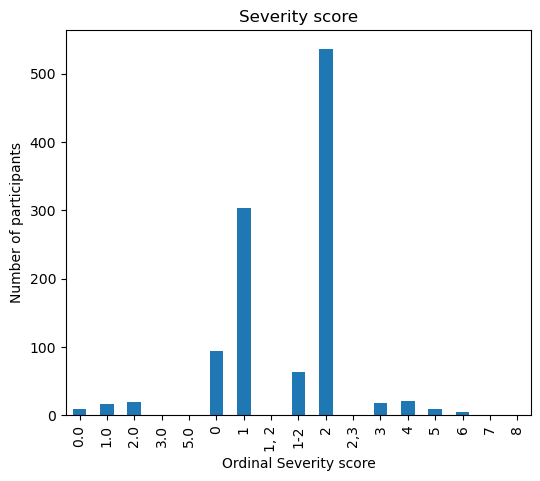

In [245]:
dfg = redcap_all_w_tcag_id.groupby(["49. Please specify Score from Ordinal Scale:"]).size()
# fig = 
dfg.plot(kind='bar', title='Severity score', ylabel='Number of participants', xlabel='Ordinal Severity score', figsize=(6, 5))
#.get_figure()
# fig.savefig("Ethnicity_bar.png", bbox_inches='tight', dpi=300)

In [240]:
redcap_all_w_tcag_id.groupby(["34. Have you received vaccination for COVID-19?  ", '1. Suspected or proven acute novel Coronavirus (nCoV) infection:   ']).size()

34. Have you received vaccination for COVID-19?    1. Suspected or proven acute novel Coronavirus (nCoV) infection:   
No                                                 No                                                                       5
                                                   Yes                                                                     68
Yes                                                No                                                                      83
                                                   Yes                                                                    842
dtype: int64

In [341]:
df = redcap_all_w_tcag_id.loc[redcap_all_w_tcag_id['seq_available'] == True][output_columns]
df.replace(r'\s+|^$|""', np.nan, regex=True,inplace=True)
# df.replace('', np.nan,inplace=True)
# df.replace(r'\s*',np.nan,regex=True).replace('',np.nan)
df.loc[df['Participant ID #:'] == "800-053"]
# df.loc[df['Participant ID #:'] == "800-053",'combined_ethnicity'] == None

,Participant ID #:,combined_ethnicity,1. Suspected or proven acute novel Coronavirus (nCoV) infection:,Close contact* with a symptomatic confirmed or probable case of \tnCoV Infection,10. Sex at Birth:,11. Estimated Age (Years OR Months),34. Have you received vaccination for COVID-19?,49. Please specify Score from Ordinal Scale:,tcag_id,seq_available
1018,800-053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23-4891-A-02-00,True
